In [2]:
import csv
import numpy as np
import pymzml
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential , Model
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.preprocessing import sequence

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

In [3]:
precision = 0.005 # m/z precision for raw data
data_per_sec = 2 # spectrum per second
half_time_window = 30 # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false

data_folder = '../data/sara_training/'
peak_clarkii= data_folder + 'clarkiiT0I1_peak_annotations.csv' # data with peak: mz, rt, Y/N
mz_clarkii = data_folder + 'clarkiiT0I1.mzML'
peak_viridis= data_folder + 'viridisT0I2_peak_annotations.csv' # data with peak: mz, rt, Y/N
mz_viridis = data_folder + 'viridisT0I2.mzML'

pickle_path = './output/pickle_training.npy'

In [4]:
def get_data_mz(data_mz ,mz , retention_time):

    run = pymzml.run.Reader(data_mz)

    data = []

    ticks_processed = 0

    for i, scan in enumerate(run):

        if scan.ms_level == 1:

            t, measure = scan.scan_time  # get scan time

            if t >= (retention_time-half_time_window):

                ticks_processed +=1

                mz_in_range = []
                for d in scan.peaks('raw'):
                    mz_scan = d[0]
                    i_scan = d[1]

                    if mz_scan >= mz - precision  and mz_scan <= mz + precision:
                        mz_in_range.append(i_scan)

                if not mz_in_range:
                    data.append(0)
                else:
                    data.append(mz_in_range[0])

                if ticks_processed == number_ticks:
                    break

    return data

def build_data_ml(path, data_mz_path, annotation=True):

    X_ = []
    y_ = []
    mz_ = []
    rt_ = []


    # get all Raw data
    with open(path, newline='') as f:

        it = 0
        reader = csv.reader(f,delimiter=';')
        for line in list(reader)[:1000]:

            spectrum = get_data_mz(data_mz_path, float(line[1]), float(line[2])*60)

            X_.append(spectrum)
            if annotation:
                y_.append(1 if line[6] == 'YES' else 0)
            else:
                y_.append(True)
            mz_.append(float(line[1]))
            rt_.append(float(line[2])*60)

            it +=1
            if it %50 == 0:
                print(it)

    return [X_, y_, mz_, rt_]

class Factory:
    def __init__(self):
        self.X_ = []
        self.y_ =  []
        self.mz_ = []
        self.rt_ =  []

    def add_data(self, path_annotation, path_mz):
        d = build_data_ml(path_annotation,path_mz )
        self.X_ += d[0]
        self.y_ +=  d[1]
        self.mz_ += d[2]
        self.rt_ +=  d[3]

    def save(self, file_out):
        with open(file_out, 'wb') as fi:
            np.save(fi, np.asanyarray([self.X_,self.y_,self.mz_,self.rt_], dtype=object))

    def load(self, file_out):
        data = np.load(file_out, allow_pickle=True)
        self.X_ = data[0]
        self.y_ =  data[1]
        self.mz_ = data[2]
        self.rt_ =  data[3]


In [5]:
# Process input files and pickle it for later (only run once)
data = Factory()
data.add_data(peak_clarkii,mz_clarkii)
data.add_data(peak_viridis,mz_viridis)
data.save(pickle_path)

50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350


In [8]:
# Load data pickled
data = np.load(pickle_path, allow_pickle=True)

X_ = data[0]
y_ =  data[1]
mz_ = data[2]
rt_ =  data[3]

'''
for i in range(len(X_)):
    color = 'green' if y_[i] == 1 else 'red'
    yn = 'YES' if y_[i] == 1 else 'NO'
    plt.title(  str(i) + ' ' + yn + ' - ' + str(mz_[i]) + ' // ' + str(float(rt_[i])))
    plt.plot(X_[i], color=color)
    plt.show()
'''


"\nfor i in range(len(X_)):\n    color = 'green' if y_[i] == 1 else 'red'\n    yn = 'YES' if y_[i] == 1 else 'NO'\n    plt.title(  str(i) + ' ' + yn + ' - ' + str(mz_[i]) + ' // ' + str(float(rt_[i])))\n    plt.plot(X_[i], color=color)\n    plt.show()\n"

In [9]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def NormalizeData(data):
    if np.max(data) - np.min(data) == 0.0:
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [10]:
df = pd.DataFrame(X_)

df['y']= y_
df['mz']= mz_
df['rt']= rt_

df['treshold_satisfied'] = df[0].apply(lambda x: 1 if np.amax(x) > intensity_treshold else 0)
df['y'] = df['y'] & df['treshold_satisfied']
df['y'] = df['y'].apply(lambda x: 1 if x == True else 0)

df['norm'] = df[0].apply(lambda x: NormalizeData(x) )

df['smooth'] = df[0].apply(lambda x: smooth(x) )
df['smooth'] = df['smooth'].apply(lambda x: x[5:-5] )

df['grad1'] = df['smooth'].apply(lambda x: np.gradient(x) )
df['grad2'] = df['grad1'].apply(lambda x: np.gradient(x) )

df['fft'] = df[0].apply(lambda x: np.fft.fft(x) )
df['fftr'] = df['fft'].apply(lambda x: np.real(x) )
df['ffti'] = df['fft'].apply(lambda x: np.real(np.imag(x)) )

In [11]:
xfft = np.hstack([np.array(df['treshold_satisfied']).reshape((len(df), -1)),np.vstack(df['fftr']), np.vstack(df['ffti'])] )
print(xfft.shape)

x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
              np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)
print(x.shape)

(994, 241)
(994, 120, 4)


In [12]:
df

,0,y,mz,rt,treshold_satisfied,norm,smooth,grad1,grad2,fft,fftr,ffti
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,407.112924,122.4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(1830.8910064697266+0j), (-1810.590459979371-...","[1830.8910064697266, -1810.590459979371, 1750....","[0.0, -27.515661838394657, 57.13847107271222, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 218.38938903808...",0,231.073496,73.8,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1708661915112...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.085433095755629, 7...","[0.0, 0.0, 0.0, 0.0, 1.0427165478778144, 3.772...","[(8529.173973083496+0j), (-5627.2446905404-900...","[8529.173973083496, -5627.2446905404, 4155.486...","[0.0, -900.8912393936953, -503.51457620629526,..."
2,"[14512.8212890625, 15471.5283203125, 18927.275...",1,388.254627,89.4,1,"[0.08571052226425582, 0.09143104289394773, 0.1...","[16984.30646835859, 17368.492186380572, 18509....","[384.1857180219813, 762.4956545239947, 1491.67...","[378.30993650201344, 553.7456176772148, 668.13...","[(3128577.0594177246+0j), (-1334907.3012342255...","[3128577.0594177246, -1334907.3012342255, 1611...","[0.0, -879171.2533476867, -367927.44320833404,..."
3,"[0, 109.23646545410156, 0, 130.23809814453125,...",1,134.117423,290.4,1,"[0.0, 0.0029103146279069935, 0.0, 0.0034698471...","[57.52058698294407, 55.68224678098707, 50.8694...","[-1.8383402019569957, -3.3255886667828776, -5....","[-1.487248464825882, -1.8750171421772475, -1.4...","[(487235.67504119873+0j), (-343772.15341900906...","[487235.67504119873, -343772.15341900906, 1789...","[0.0, 136215.4095432649, -21500.875264179896, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,177.06155,624.6,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(77865.11724090576+0j), (-64991.90851401366+3...","[77865.11724090576, -64991.90851401366, 32680....","[0.0, 39149.77058196768, -63233.24215895787, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
989,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,566.888123,372.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(782262.0668945312+0j), (-91300.7861375781+41...","[782262.0668945312, -91300.7861375781, 63688.5...","[0.0, 414586.42305416986, 51601.92428541789, 7..."
990,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,430.914116,372.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(1173563.4569702148+0j), (-145697.11259987013...","[1173563.4569702148, -145697.11259987013, 9439...","[0.0, 613753.2974744083, 87812.60482923561, 97..."
991,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,906.824345,373.8,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(671559.0030517578+0j), (-81267.03598285525+3...","[671559.0030517578, -81267.03598285525, 41872....","[0.0, 356934.080593044, 53232.14920768077, 581..."
992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,196.095473,402.6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(26193.781784057617+0j), (-2797.6421614450846...","[26193.781784057617, -2797.

In [13]:
def ret_mats(df):
    xfft = np.hstack( [np.array(df['treshold_satisfied']).reshape((len(df), -1)), np.vstack(df['fftr']), np.vstack(df['ffti'])] )
    x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
              np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)
    y = df.y.map(lambda x : float(x))

    return x,xfft,y

train, test = train_test_split(df, test_size=0.3)

mats={'train':ret_mats(train), 'test':ret_mats(test)}

In [14]:
model = None
tf.config.run_functions_eagerly(True)

inputvec = Input(shape=(120,4))
inputfft = Input(shape=(241))

lstm = LSTM(50,  return_sequences = True , return_state = False, dropout=0.2,
    recurrent_dropout=0.2, go_backwards=True)

whole_seq_output = lstm(inputvec)

lstm2 = LSTM(40, return_sequences = True , return_state = False, dropout=0.2,
    recurrent_dropout=0.2, go_backwards=True )

whole_seq_output2 = lstm2(whole_seq_output)

lstm3 = LSTM(30, return_sequences = False , return_state = True, dropout=0.2,
    recurrent_dropout=0.2, go_backwards=True )

final_memory_state, final_carry_state, whole_seq_output = lstm3(whole_seq_output2)

dense_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state,whole_seq_output, inputfft])
dense_input = tf.keras.layers.Dropout(.2)(dense_input)
output1 = Dense(50)(dense_input)
output1 = tf.keras.layers.Dropout(.2)(output1)
output = Dense(25)(output1)
final = Dense(1,activation = 'sigmoid')(output)


model = Model( inputs = [inputvec,inputfft] , outputs = final)

opt = tf.keras.optimizers.Adam( learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 4)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 120, 50)      11000       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 120, 40)      14560       ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  [(None, 30),         8520        ['lstm_1[0][0]']                 
                                 (None, 30),                                                  

In [15]:
history = model.fit([mats['train'][0], mats['train'][1]], mats['train'][2], epochs=100, batch_size=250)


Epoch 1/100


/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-08-20 20:41:37.151161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 3s 962ms/step - loss: 71879.2734 - accuracy: 0.4604
Epoch 2/100
3/3 [==============================] - 3s 921ms/step - loss: 75681.9062 - accuracy: 0.4662
Epoch 3/100
3/3 [==============================] - 3s 932ms/step - loss: 41353.1172 - accuracy: 0.4446
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 39881.0820 - accuracy: 0.4676
Epoch 5/100
3/3 [==============================] - 3s 973ms/step - loss: 44404.5938 - accuracy: 0.4489
Epoch 6/100
3/3 [==============================] - 3s 990ms/step - loss: 33224.4766 - accuracy: 0.4619
Epoch 7/100
3/3 [==============================] - 3s 973ms/step - loss: 24913.9883 - accuracy: 0.4835
Epoch 8/100
3/3 [==============================] - 3s 973ms/step - loss: 31890.3535 - accuracy: 0.4791
Epoch 9/100
3/3 [==============================] - 3s 985ms/step - loss: 23370.6758 - accuracy: 0.4820
Epoch 10/100
3/3 [==============================] - 3s 930ms/step - loss: 19685.6641 - a

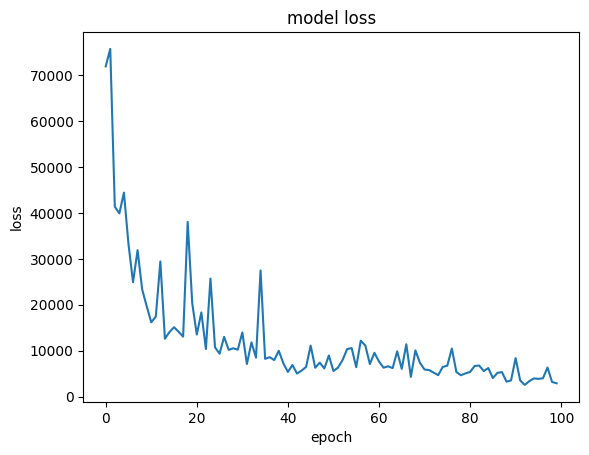

In [18]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

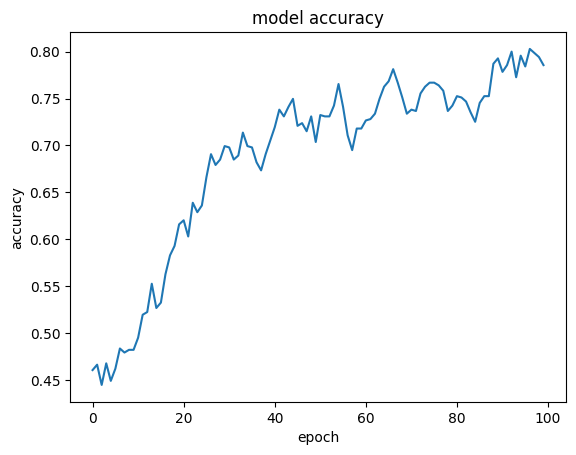

In [19]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


In [20]:
scores = model.evaluate([ mats['test'][0], mats['test'][1]], mats['test'][2], verbose=1)

/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 [==============================] - 4s 362ms/step - loss: 14016.4229 - accuracy: 0.7826


In [24]:
model.save('output/model_peak')

INFO:tensorflow:Assets written to: output/model_peak/assets


In [21]:
pre_raw = model.predict([ mats['test'][0], mats['test'][1]])

pre = []

for pr in pre_raw:
    if pr > 0.5:
        pre.append(1)
    else:
        pre.append(0)


/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 [==============================] - 4s 352ms/step


In [ ]:
false = 0
small_all = 0

fp = 0
tp = 0
fn = 0
tn = 0

fp_small = 0
fn_small = 0


cpt =0

for p in pre:

    df_key = list(mats['test'][2].keys())[cpt]

    dfdf = df[0][df_key]

    if max(dfdf) < 8000:
        small_all +=1

    if p != list(mats['test'][2])[cpt]:

        if p == 1:
            fp +=1
        else:
            fn +=1


        plt.title( str(df['mz'][df_key]) )
        color = 'green' if p == 1 else 'red'
        plt.plot(dfdf , color = color)
        plt.show()

        if max(dfdf) < 8000:
            if p == 1:
                fp_small +=1
            else:
                fn_small +=1

        false +=1


    else:
        if p == 1:
            tp +=1
        else:
            tn +=1

    cpt +=1



In [23]:
total = len( mats['test'][0])
print('Predicted Features: ', total)
print('False Predictions: ', false)
print('% Good: ', (total-false)/total*100)
print('\n')

print('Precision: ', (100 * tp)/ (tp+fp) )
print('Recall: ', (100 * tp/ (tp+fn) ))
print('\n')

print('< 8000  FP: ', fp_small)
print('< 8000  FN: ', fn_small)
print('< 8000 Totals: ', small_all)
print('\n')

print('Corrected Precision: ', (100 * tp)/ (tp+fp-fp_small) )
print('Corrected Recall: ', (100 * tp/ (tp+fn-fn_small) ))
print('Corrected % Good: ', (total-false+fp_small)/total*100)

Predicted Features:  299
False Predictions:  65
% Good:  78.26086956521739


Precision:  64.63414634146342
Recall:  93.80530973451327


< 8000  FP:  33
< 8000  FN:  0
< 8000 Totals:  150


Corrected Precision:  80.91603053435115
Corrected Recall:  93.80530973451327
Corrected % Good:  89.29765886287625
